[連結文字](https://)# 讀取資料跟匯入相關套件

In [ ]:
#pip install sklearn
import pandas as pd
import numpy as np

# 繪圖相關套件
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use( 'ggplot' ) 

# 標籤編碼(Label)、獨熱編碼(OneHot)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
# 決策樹(Decision Tree)
from sklearn.tree import DecisionTreeClassifier
# 隨機森林(Random Forest)
from sklearn.ensemble import RandomForestClassifier
#Logistic
from sklearn.linear_model import LogisticRegression

from IPython.display import display
import warnings
warnings.filterwarnings( 'ignore' )

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print( f'train {train.shape}' ) #f-string {}內填入替換的字串
display( train.head() )

print( f'\ntest {test.shape}' )
display( test.head() )

train (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



test (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


合併train和test

In [ ]:
df_data = train.append(test)
df_data


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


確認遺失值

In [ ]:
df_data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

# 探索數據
 看什麼樣的特徵會影響到生還率

## 性別(Sex)

,Sex,Survived
0,female,0.742
1,male,0.189


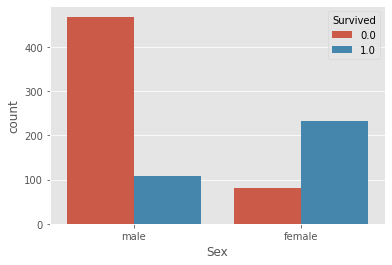

In [ ]:
sns.countplot(df_data['Sex'], hue=df_data['Survived'])
display(df_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().round(3))

女性的生還率明顯高於男性，有74.2%，而男性都差不多死光了僅剩18.9%

## 艙等(Cabin)

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


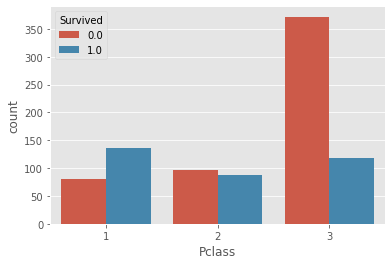

In [ ]:
sns.countplot(df_data['Pclass'], hue=df_data['Survived'])
df_data[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().round(3)

艙等數字越少艙等等級越高，我們可以看到隨著越高的艙等，生還的比例也越高


## 票價(Fare)
 對票價進行分組，然後觀察他們的生存率
 

  注意有個遺漏值，要補上

In [ ]:
df_data['Fare'].fillna( df_data.Fare.median(), inplace=True )

由於只有一項遺失值，我們填入中位數





In [ ]:
# 計算 Fare 欄位各個百分位數(Percentile)
P_all = [ np.percentile( df_data.Fare, q=i ) for i in np.arange(0,101) ] 
Pth_Percentile = pd.DataFrame( { 'Q':list(range(101)), 'Value':P_all } )

# The first、second and third quartile(i,e., the 25th、50th and 75th Percentile)
Q1 = Pth_Percentile.iloc[ 25, 1 ]
Q2 = Pth_Percentile.iloc[ 50, 1 ]
Q3 = Pth_Percentile.iloc[ 75, 1 ]
IQR = Q3 - Q1

print( f'Q1 = {Q1}' )
print( f'Q2 = {Q2} = Median' )
print( f'Q3 = {Q3}' )
print( f'Maximum = {df_data.Fare.max()}')
print( f'IQR = Q3 - Q1 = {IQR}' )
print( f'Q3 + 1.5IQR = {Q3+1.5*IQR}' )

# 依照四分位數，對 Fare 欄位進行分組
Fare_bin = [ 0, Q1, Q2, Q3, Q3+1.5*IQR, df_data.Fare.max() ]
df_data[ 'Fare_Group' ] = pd.cut( df_data.Fare.values, Fare_bin )

# 計算每個分組中的資料筆數
Group_Counts = df_data[ 'Fare_Group' ].value_counts().reset_index()    
Group_Counts.columns = [ 'Fare_Group', 'Counts' ]
Group_Counts.sort_values( by='Fare_Group' )

Q1 = 7.8958
Q2 = 14.4542 = Median
Q3 = 31.275
Maximum = 512.3292
IQR = Q3 - Q1 = 23.379199999999997
Q3 + 1.5IQR = 66.34379999999999


,Fare_Group,Counts
2,"(0.0, 7.896]",320
1,"(7.896, 14.454]",321
0,"(14.454, 31.275]",328
4,"(31.275, 66.344]",152
3,"(66.344, 512.329]",171


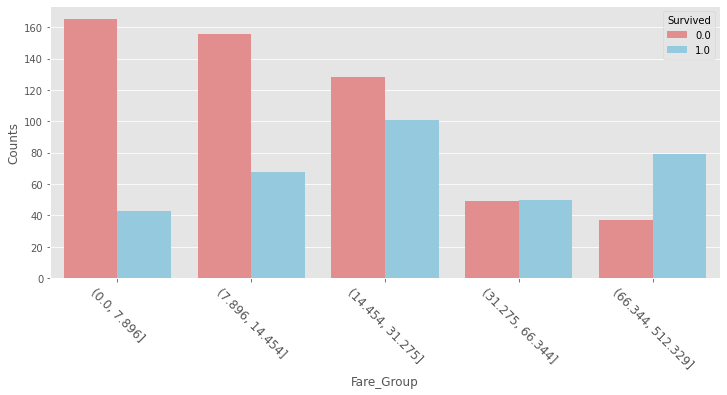

In [ ]:
plt.subplots( figsize=(12,5) )
sns.countplot( df_data.Fare_Group, hue=df_data.Survived, palette=['lightcoral','skyblue'] )
plt.ylabel( 'Counts' ) 
plt.xticks( rotation=-45, fontsize=12 )
plt.show()

可以發現票價越高，生存率也就越大，我們把票價一樣按照4分位數，切成5個區間



In [ ]:
df_data['FareBin'] = pd.qcut(df_data['Fare'], 5)


In [ ]:
# 刪除 Fare_Group 欄位 
df_data.drop( ['Fare','Fare_Group'], axis=1, inplace=True )

# 特徵工程

## 處理字串欄位

### 姓名(Name)
我們提取姓名的title


In [ ]:
df_data['Title'] = df_data.Name.str.split(', ', expand=True)[1] #Yutung,Mr.Huang → Mr.Huang
df_data['Title'] = df_data.Title.str.split('.', expand=True)[0] #Mr.Huang → Mr
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

然後我們合併同樣性別或關係的稱謂

In [ ]:
df_data['Title'] = df_data.Title.replace( ['Don','Rev','Dr','Major','Lady','Sir','Col','Capt','the Countess','Jonkheer','Dona'], 'Rare' )
df_data['Title'] = df_data.Title.replace( ['Ms','Mlle'], 'Miss' )
df_data['Title'] = df_data.Title.replace( 'Mme', 'Mrs' )
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [ ]:
# 刪除原始資料中的 Name 欄位 
df_data.drop( 'Name', axis=1, inplace=True )

### 船票號碼(Ticket)
我們合理假設ticket前面的英文字母代表相同的區域，所以我們截取ticket前面英文字母的部分，當作倉房的位置分區

In [ ]:
df_data['Ticket_info'] = df_data.Ticket.apply( lambda x:x.replace('.','').replace('/','').strip().split(' ')[0] if not x.isdigit() else 'X')
#strip 去除引號 isdigit確認有沒有包含前面的英文字母
df_data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [ ]:
# 刪除原始資料中的 Ticket 欄位 
df_data.drop( 'Ticket', axis=1, inplace=True )

## 填補遺漏值

In [ ]:
df_data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Sex               0
Age             263
SibSp             0
Parch             0
Cabin          1014
Embarked          2
FareBin           0
Title             0
Ticket_info       0
dtype: int64

Survived裡面的遺漏值是我們要預測的，所以不理他

## 年齡（Age)
根據稱謂對應的年齡平均值填入


因為年齡缺的不少，我們擔心缺失值會影響預測 所以我們先來觀察缺失值分佈的情況

Sex,female,male,All
Has_Age,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


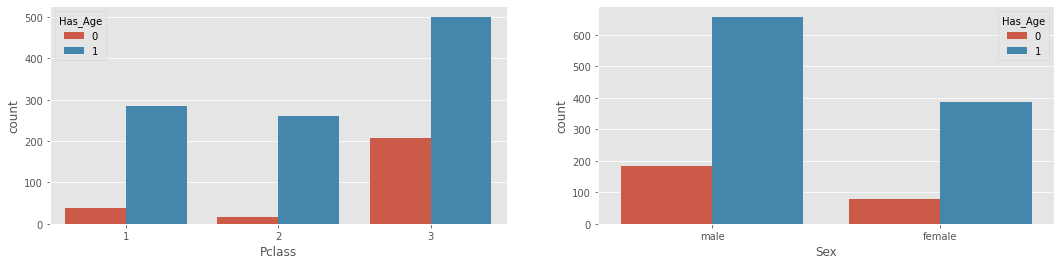

In [ ]:
df_data['Has_Age'] = df_data['Age'].isnull().map(lambda x : 0 if x == True else 1)
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
ax1 = sns.countplot(df_data['Pclass'],hue=df_data['Has_Age'],ax=ax1)
ax2 = sns.countplot(df_data['Sex'],hue=df_data['Has_Age'],ax=ax2)
pd.crosstab(df_data['Has_Age'],df_data['Sex'],margins=True).round(3)

我們可以看到年齡缺失值蠻大部分在3等艙，所以如果年齡真的是個重要特徵，我們對3等艙的觀察可能就會失真，保守一點的做法就是觀察1,2等倉中年齡對生存率的影響

而性別的部分，女性大概是16.7%遺失，男性是21.9%，男性稍微多了一點，如果年齡真的有影響的話可能可以搭配男性區分出更多的生還者

接著我們來看1,2等艙中年齡對存活率的影響

Text(0.5, 1.0, 'Age vs Survived in Pclass = 1 and  2')

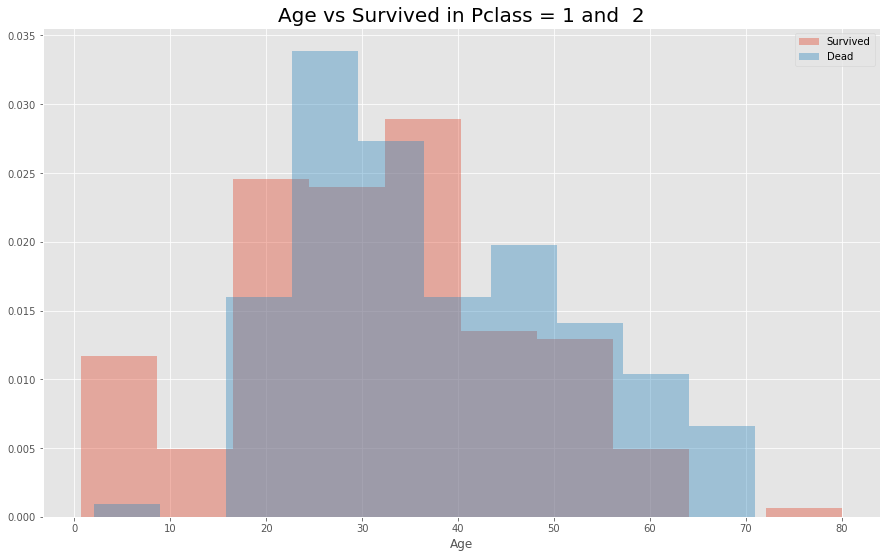

In [ ]:

Has_Age_P12_Survived = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 1) )
Has_Age_P12_Dead = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 0) )

fig, ax = plt.subplots( figsize = (15,9) )
ax = sns.distplot(df_data.loc[Has_Age_P12_Survived, 'Age'],kde=False,bins=10,norm_hist=True,label='Survived') 
ax = sns.distplot(df_data.loc[Has_Age_P12_Dead, 'Age'],kde=False,bins=10,norm_hist=True,label='Dead')
ax.legend()
ax.set_title('Age vs Survived in Pclass = 1 and  2',fontsize = 20)

我們可以看到左邊紅色多出了一塊，也就是存活率比較高，大概16，17歲以下，代表說青少年有比較高的生存率,然後我們也看到當>17歲，年齡就不算一個太顯著的特徵，所以根據前面所述，我們就把年齡分成大於17跟小於17

現在我們計算稱謂(title)的年齡平均值，我們在用平均直去填入Age的遺失值

In [ ]:
# 計算每個 Title 的年齡平均值及中位數
Age_Mean = df_data[['Title','Age']].groupby( by=['Title'] ).mean()
Age_Median = df_data[['Title','Age']].groupby( by=['Title'] ).median()

Age_Mean.columns = ['Age Mean']
Age_Median.columns = ['Age Median']
Age_Mean.reset_index( inplace=True )
Age_Median.reset_index( inplace=True )

display( Age_Median )
display( Age_Mean )

,Title,Age Median
0,Master,4.0
1,Miss,22.0
2,Mr,29.0
3,Mrs,35.0
4,Rare,47.5


,Title,Age Mean
0,Master,5.482642
1,Miss,21.824366
2,Mr,32.252151
3,Mrs,36.918129
4,Rare,45.178571


In [ ]:
# 利用每個 Title 的年齡平均數，填補每個 Title 所對應 Age 的缺漏值
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Master'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Master','Age Mean'][0]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Miss'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Miss','Age Mean'][1]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mr'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mr','Age Mean'][2]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mrs'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mrs','Age Mean'][3]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Rare'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Rare','Age Mean'][4]



In [ ]:
# 乘客年齡是否未滿17歲(是：1；否：0)
df_data[ 'is_Age_17' ] = (df_data.Age<17)*1
df_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,FareBin,Title,Ticket_info,Has_Age,is_Age_17
0,1,0.0,3,male,22.000000,1,0,NaN,S,"(-0.001, 7.854]",Mr,A5,1,0
1,2,1.0,1,female,38.000000,1,0,C85,C,"(41.579, 512.329]",Mrs,PC,1,0
2,3,1.0,3,female,26.000000,0,0,NaN,S,"(7.854, 10.5]",Miss,STONO2,1,0
3,4,1.0,1,female,35.000000,1,0,C123,S,"(41.579, 512.329]",Mrs,X,1,0
4,5,0.0,3,male,35.000000,0,0,NaN,S,"(7.854, 10.5]",Mr,X,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,male,32.252151,0,0,NaN,S,"(7.854, 10.5]",Mr,A5,0,0
414,1306,NaN,1,female,39.000000,0,0,C105,C,"(41.579, 512.329]",Rare,PC,1,0
415,1307,NaN,3,male,38.500000,0,0,NaN,S,"(-0.001, 7.854]",Mr,SOTONOQ,1,0
416,1308,NaN,3,male,32.252151,0,0,NaN,S,"(7.854, 10.5]",Mr,X,0,0


### 船艙號碼(Cabin)
我們取第一個英文字母作為分類的標籤

In [ ]:
# 觀察 Cabin 中的種類
df_data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [ ]:
# 取出 Cabin 中的第一個字母，如果為缺漏值，則以 NoCabin 表示
df_data['Cabin'] = df_data['Cabin'].apply( lambda x:str(x)[0] if not pd.isnull(x) else 'NoCabin' )
df_data['Cabin'].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [ ]:
label = LabelEncoder()
df_data['FareBin_Encode'] = label.fit_transform(df_data['FareBin'])


### 登船港口(Embarked)
填補次數最多的港口 'S'


In [ ]:
# 計算 Embarked 欄位中每個相異值的次數
display( df_data['Embarked'].value_counts() )
# 填補 Embarked 欄位的缺漏值
df_data['Embarked'].fillna( 'S', inplace=True )


S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [ ]:
#最後我們檢查還有沒有遺失值
df_data.isna().sum()

PassengerId         0
Survived          418
Pclass              0
Sex                 0
Age                 0
SibSp               0
Parch               0
Cabin               0
Embarked            0
FareBin             0
Title               0
Ticket_info         0
Has_Age             0
is_Age_17           0
FareBin_Encode      0
dtype: int64

## 編碼

### 票價(Fare)
我們把剛剛分好的票價做標籤編碼


In [ ]:
label = LabelEncoder()
df_data['FareBin_Encode'] = label.fit_transform(df_data['FareBin'])


### 登船港口(Embarked) 



In [ ]:
# OneHot Encoding
OneHot_Embarked = pd.get_dummies( df_data.Embarked, prefix='Embarked' )

# 合併 Embarked 編碼後的欄位
df_data = pd.concat( [ df_data, OneHot_Embarked ], axis=1 )
df_data.drop( 'Embarked', axis=1, inplace=True )

### 性別(Sex)

In [ ]:
# Label Encoding
Sex_mapping = { 'male':0, 'female':1 }
df_data[ 'Sex' ] = df_data.Sex.map( Sex_mapping )

#拆分Train和Test

先來看看我們特徵工程完的資料

In [ ]:
# 檢視特徵工程後的資料
print( f'Shape of data after feature engineering = {df_data.shape}' )
df_data.head()

Shape of data after feature engineering = (1309, 17)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,FareBin,Title,Ticket_info,Has_Age,is_Age_17,FareBin_Encode,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,0,22.0,1,0,NoCabin,"(-0.001, 7.854]",Mr,A5,1,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,C,"(41.579, 512.329]",Mrs,PC,1,0,4,1,0,0
2,3,1.0,3,1,26.0,0,0,NoCabin,"(7.854, 10.5]",Miss,STONO2,1,0,1,0,0,1
3,4,1.0,1,1,35.0,1,0,C,"(41.579, 512.329]",Mrs,X,1,0,4,0,0,1
4,5,0.0,3,0,35.0,0,0,NoCabin,"(7.854, 10.5]",Mr,X,1,0,1,0,0,1


In [ ]:
#刪除FareBin
df_data.drop(['FareBin'],axis=1,inplace=True)

In [ ]:
print( f'Shape of data after feature engineering = {df_data.shape}' )
df_data.head()

Shape of data after feature engineering = (1309, 16)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Title,Ticket_info,Has_Age,is_Age_17,FareBin_Encode,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,0,22.0,1,0,NoCabin,Mr,A5,1,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,C,Mrs,PC,1,0,4,1,0,0
2,3,1.0,3,1,26.0,0,0,NoCabin,Miss,STONO2,1,0,1,0,0,1
3,4,1.0,1,1,35.0,1,0,C,Mrs,X,1,0,4,0,0,1
4,5,0.0,3,0,35.0,0,0,NoCabin,Mr,X,1,0,1,0,0,1


將類別形態的欄位轉成整數

In [ ]:
for col in ['Title','Ticket_info','Cabin']:
    df_data[col] = df_data[col].astype('category').cat.codes

df_data.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Title,Ticket_info,Has_Age,is_Age_17,FareBin_Encode,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,0,22.0,1,0,7,2,2,1,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,2,3,14,1,0,4,1,0,0
2,3,1.0,3,1,26.0,0,0,7,1,31,1,0,1,0,0,1
3,4,1.0,1,1,35.0,1,0,2,3,36,1,0,4,0,0,1
4,5,0.0,3,0,35.0,0,0,7,2,36,1,0,1,0,0,1


然後產生Train和Test


In [ ]:
# 產生訓練集和測試集
train = df_data[ pd.notnull(df_data.Survived) ]
test = df_data[ pd.isnull(df_data.Survived) ]

# 訓練集刪除 PassengerId 欄位；
# 測試集刪除 PassengerId 與 Survived 欄位
train.drop( ['PassengerId'], axis=1, inplace=True )
test.drop( ['PassengerId','Survived'], axis=1, inplace=True )

# 將測試集中的標籤欄位 Survived 單獨拆出
y_train = train.Survived
X_train = train.drop( ['Survived'], axis=1 )

print( f'Shape of X_train = {X_train.shape}' )
print( f'Shape of y_train = {y_train.shape}' )
print( f'Shape of test = {test.shape}' )

Shape of X_train = (891, 14)
Shape of y_train = (891,)
Shape of test = (418, 14)


## 特徵重要性

In [ ]:
# 建立決策樹模型
DTC = RandomForestClassifier( )
# 自變數、應變數進行擬合
DTC.fit( X_train, y_train )

# 排序特徵重要性(由大到小)
col_names = X_train.columns
importances = DTC.feature_importances_
Feature_Rank = pd.DataFrame( { 'Feature_Name':col_names, 'Importance':importances } )
Feature_Rank.sort_values( by='Importance', ascending=False, inplace=True ) 
Feature_Rank

,Feature_Name,Importance
2,Age,0.232598
1,Sex,0.195832
6,Title,0.114528
10,FareBin_Encode,0.089606
0,Pclass,0.078991
5,Cabin,0.074326
7,Ticket_info,0.055302
3,SibSp,0.051230
4,Parch,0.035840
13,Embarked_S,0.017889


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#apply SelectKBest class to extract top 5 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 5 best features

             Specs       Score
1              Sex  170.348127
10  FareBin_Encode   89.947140
5            Cabin   55.444176
2              Age   40.110302
0           Pclass   30.873699
11      Embarked_C   20.464401
9        is_Age_17   11.861523
4            Parch   10.097499
13      Embarked_S    5.489205
3            SibSp    2.581865


## 隨機森林

In [ ]:
# 隨機森林參數：
# n_estimators: 樹的數量(default=10)。
# min_samples_leaf: 最終葉節點最少樣本數(default=1)；
#                   當樣本不大時，可不設定使用預設，若樣本數量非常大時，則推薦增加此參數值。
# min_samples_split:節點再劃分時所需的最小樣本數(default=2)；
#                   當樣本不大時，可不設定使用預設，若樣本數量非常大時，則推薦增加此參數值。
# oob_score: 是否採用袋外樣本(out-of-bag samples)來評估模型的準確度(default=False)。
# n_job：同時可以使用的處理器
RFC = RandomForestClassifier( n_estimators = 15 ,
                              min_samples_split = 20,
                              min_samples_leaf = 1,
                              oob_score = True,
                              random_state = 1,
                              n_jobs = -1 ) 

In [ ]:
RFC_2 = RandomForestClassifier( n_estimators = 16,
                                min_samples_split = 20,
                                min_samples_leaf = 1,
                                oob_score = True,
                                random_state = 1,
                                n_jobs = -1 ) 

# 篩選部份特徵欄位餵入模型進行訓練
SelectedFeatures = ['Sex','Pclass','FareBin_Encode','is_Age_17']
RFC_2.fit( X_train[SelectedFeatures], y_train )
y_pred = RFC_2.predict( X_train[SelectedFeatures])

print( f'Selected Features :\n   {SelectedFeatures}' )
print( 'oob_score = {:.6f}'.format(RFC_2.oob_score_) )

Selected Features :
   ['Sex', 'Pclass', 'FareBin_Encode', 'is_Age_17']
oob_score = 0.812570


In [ ]:
Test_pred_rfc2 = RFC_2.predict(test[SelectedFeatures])

submit['Survived'] = Test_pred_rfc2.astype(int)
submit.to_csv('Titanic_RandomForest_rfc2.csv',index =False)
print('預測結果：')
submit

預測結果：


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


上傳結果是0.77751

In [ ]:
#其他index
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = confusion_matrix(y_train,y_pred)
print(cm)
print(classification_report(y_train,y_pred))


[[517  32]
 [122 220]]
              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87       549
         1.0       0.87      0.64      0.74       342

    accuracy                           0.83       891
   macro avg       0.84      0.79      0.81       891
weighted avg       0.83      0.83      0.82       891



我們用iphone faceID當作例子

True/False是預測的正確與否,Positive/Negetive是預測的方向

TP(True Positive)是你的臉，iphone也預測是你的臉,也順利解鎖了，也就是所謂的『正確的正向預測』

FN(False Negative)是你的臉，不過iphone沒有認出來沒有解鎖『錯誤的負向預測』

TN(True Negative)不是你的臉，iphone也知道不是你的臉，最後沒有開『正確的負向預測』

FP(False Positive)不是你的臉，iphone卻預測是你的臉，結果解鎖『錯誤的正向預測』

所以回到前面那個混淆矩陣，



517個人是真的死而且我們預測死的，

32個人是真的死不過我們預測他活了，

122個人是真活了不過我們預測死了，

220個是真活了而且我們也預測活了，


Precision(精確度）= 全部我們預測活的220+32=252中 220我們預測對了所以是220/252 =87%

recall(召回率) = 真的活的342人中220我們預測對了所以召回率是220/342=64%

F1-score = 2 * Precision * Recall / (Precision+recall) 上面兩個的調和平均 算是一個簡略的指標來看模型的表現

accuracy(準確率) =預測對的除以總數 = 517+220/891 =82.7%

macroavg(巨集平均) =所有類別的指標除以類別數 = 81%+87%/2 =84%

weighted avg(加權平均) 


###  gridsearchcv


In [ ]:
from sklearn.model_selection import GridSearchCV
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [16,250,1000],#樹的數量
    'max_features': ['auto', 'sqrt', 'log2'],#單個決策樹使用特徵的最大數量
    'max_depth' : [4,5,6,7,8],#最大深度
    'criterion' :['gini', 'entropy']#不同的標準
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train[SelectedFeatures], y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [ ]:
CV_rfc.best_params_


{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 16}

In [ ]:
rfc1=RandomForestClassifier(criterion= 'gini',
 max_depth= 6,
 max_features= 'auto',
 n_estimators=16)
rfc1.fit(X_train[SelectedFeatures],y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=16,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rfc1.score(X_train[SelectedFeatures],y_train)


0.8282828282828283

In [ ]:
Test_pred_rfc1 = rfc1.predict(test[SelectedFeatures])

submit['Survived'] = Test_pred_rfc1.astype(int)
submit.to_csv('Titanic_RandomForest_rfc1.csv',index =False)
print('預測結果：')
submit

預測結果：


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


0.77272

## XGBoost

In [ ]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(learning_rate=0.02,)


In [ ]:
params = {
       
        'min_child_weight': [1, 5, 10],#最小葉子節點樣本權重和
        'gamma': [0.5, 1, 1.5, 2, 5],#Gamma指定了節點分裂所需的最小損失函數下降值。
        'subsample': [0.6, 0.8, 1.0],#控制對於每棵樹，隨機采樣的比例
        'colsample_bytree': [0.6, 0.8, 1.0],#控制每棵隨機采樣的列數的占比(每一列是一個特征)。
        'max_depth': [3, 4, 5]#樹的最大深度
       
      }

In [ ]:
CV_xgb = GridSearchCV(estimator=xgbc, param_grid=params, cv= 5)
CV_xgb.fit(X_train[SelectedFeatures], y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.02, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_child

In [ ]:
CV_xgb.best_params_


{'colsample_bytree': 1.0,
 'gamma': 0.5,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 0.8}

In [ ]:
xgb1=XGBClassifier(colsample_bytree= 1.0,
 gamma= 0.5,
 max_depth= 5,
 min_child_weight= 1,
 subsample= 0.8)
xgb1.fit(X_train[SelectedFeatures],y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [ ]:
xgb1.score(X_train[SelectedFeatures],y_train)

0.8271604938271605

In [ ]:
XGB_pred = xgb1.predict(test[SelectedFeatures])

submit['Survived'] = XGB_pred.astype(int)
submit.to_csv('Titanic_RandomForest_XGB.csv',index =False)
print('預測結果：')
submit

預測結果：


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


0.77272

## LogisticRegression

In [ ]:
clf = LogisticRegression()


In [ ]:
params_LR ={'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}



In [ ]:
CV_LR = GridSearchCV(estimator=clf, param_grid=params_LR, cv= 5)
CV_LR.fit(X_train[SelectedFeatures], y_train)

penalty：懲罰項 C：正則化係數λ的倒數

In [ ]:
CV_LR.best_params_


In [ ]:
LR1 = LogisticRegression(C=5,penalty='l2')
LR1.fit(X_train[SelectedFeatures], y_train)


In [ ]:
LR1.score(X_train[SelectedFeatures], y_train)

In [ ]:
LR1_pred = LR1.predict(Test[SelectedFeatures])

submit['Survived'] = LR1_pred.astype(int)
submit.to_csv('Titanic_RandomForest_LR1.csv',index =False)
print('預測結果：')
submit

In [ ]:
0.77511